In [15]:
import pandas as pd

df = pd.read_csv('syb-18-chapter_22_shipping_table_22.5.csv')
df.head()

,Year,POL (Crude & Product),Fertiliser,Fertiliser Raw Material,Iron Ore,Coal,Foodgrains,Others,Total
0,2000-01,108.38,3.03,10.31,40.46,54.52,1.98,62.46,281.13
1,2001-02,103.28,3.49,10.48,45.76,51.25,3.91,69.40,287.58
2,2002-03,109.57,2.88,10.29,50.56,53.04,8.54,78.68,313.55
3,2003-04,122.16,2.86,8.94,58.85,54.90,6.84,90.25,344.80
4,2004-05,126.44,3.85,10.67,76.20,60.65,3.84,102.11,383.76


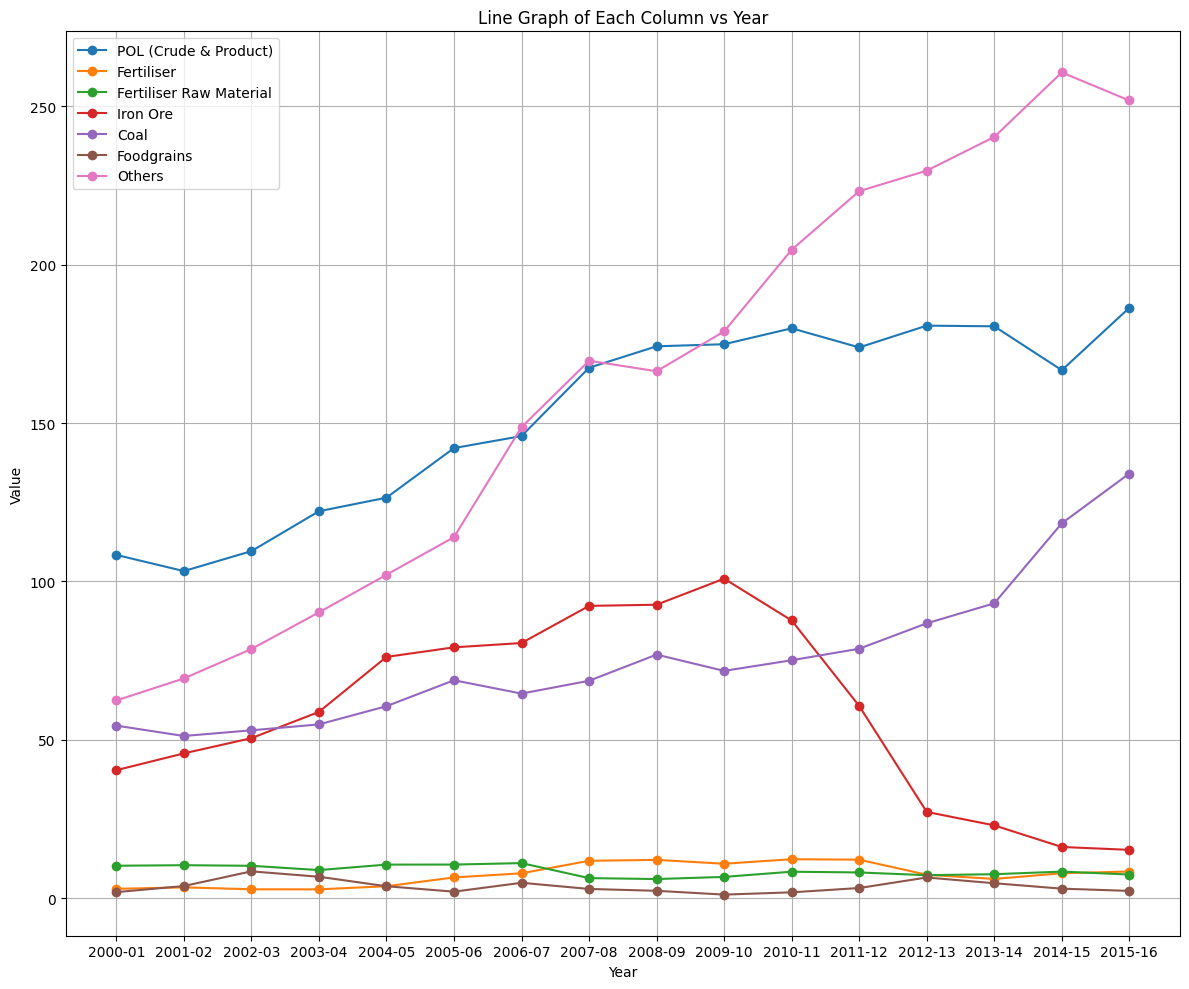

In [16]:
plt.figure(figsize=(12, 10))
for col in data_cols:
    plt.plot(df[year_col], df[col], marker='o', label=col)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Line Graph of Each Column vs Year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


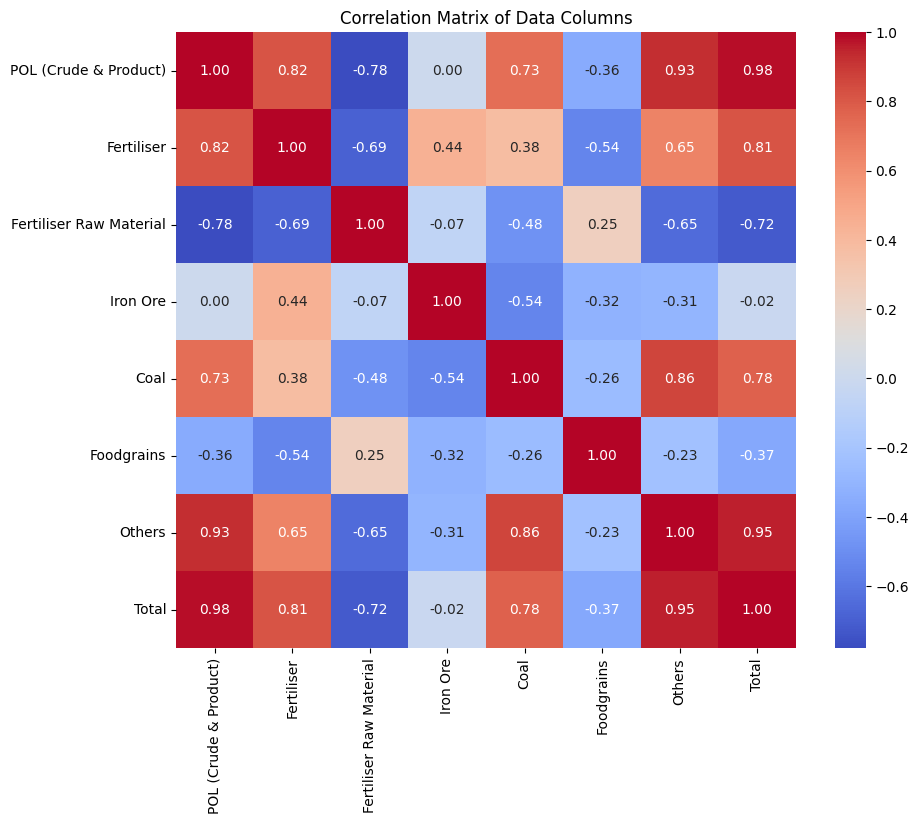

In [5]:
# Visualize the correlation matrix (excluding the year column)
import seaborn as sns

corr = df.iloc[:, 1:].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Data Columns')
plt.show()

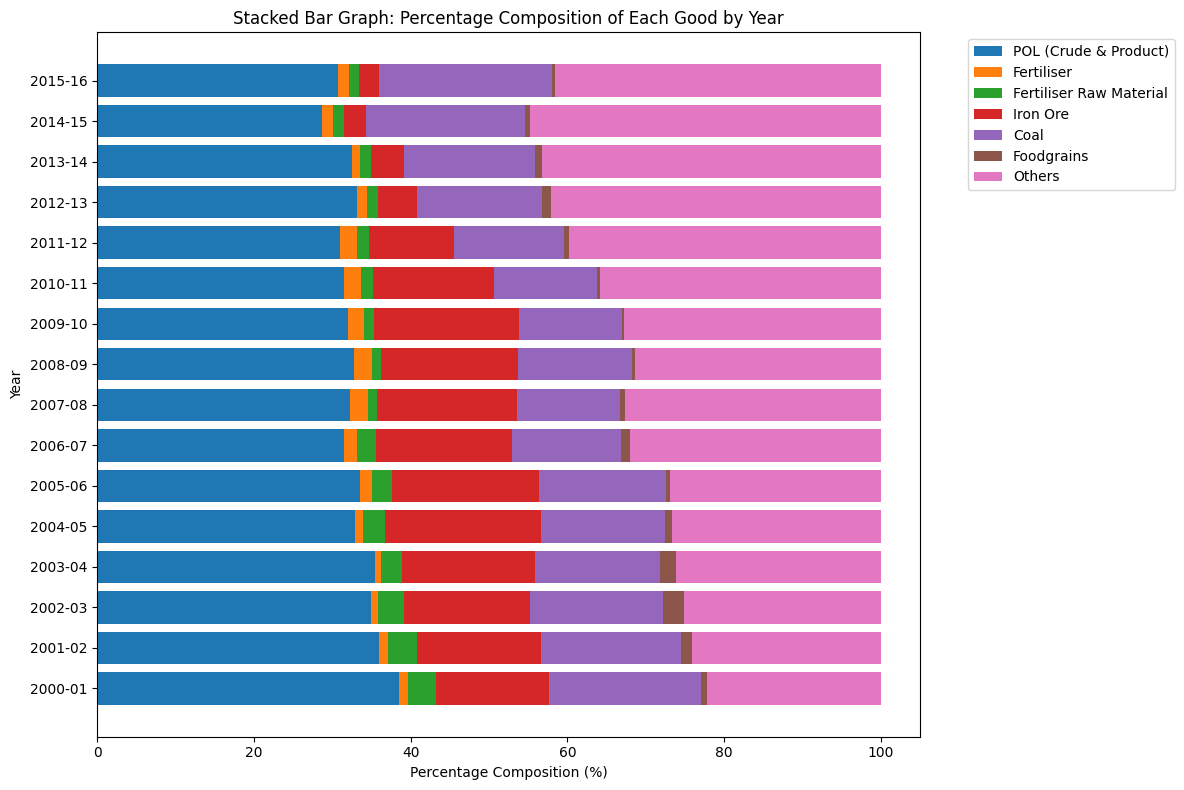

In [20]:
# Create a stacked bar graph of percentage composition for each good by year (excluding the total column)

# Exclude the 'Total' column if present (case-insensitive match)
data_cols = [col for col in df.columns[1:] if 'total' not in col.lower()]
df_percent = df.copy()
df_percent[data_cols] = df_percent[data_cols].div(df_percent[data_cols].sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 8))
bottom = None
for col in data_cols:
    plt.barh(df[year_col], df_percent[col], left=bottom, label=col)
    if bottom is None:
        bottom = df_percent[col].copy()
    else:
        bottom += df_percent[col]
plt.xlabel('Percentage Composition (%)')
plt.ylabel('Year')
plt.title('Stacked Bar Graph: Percentage Composition of Each Good by Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

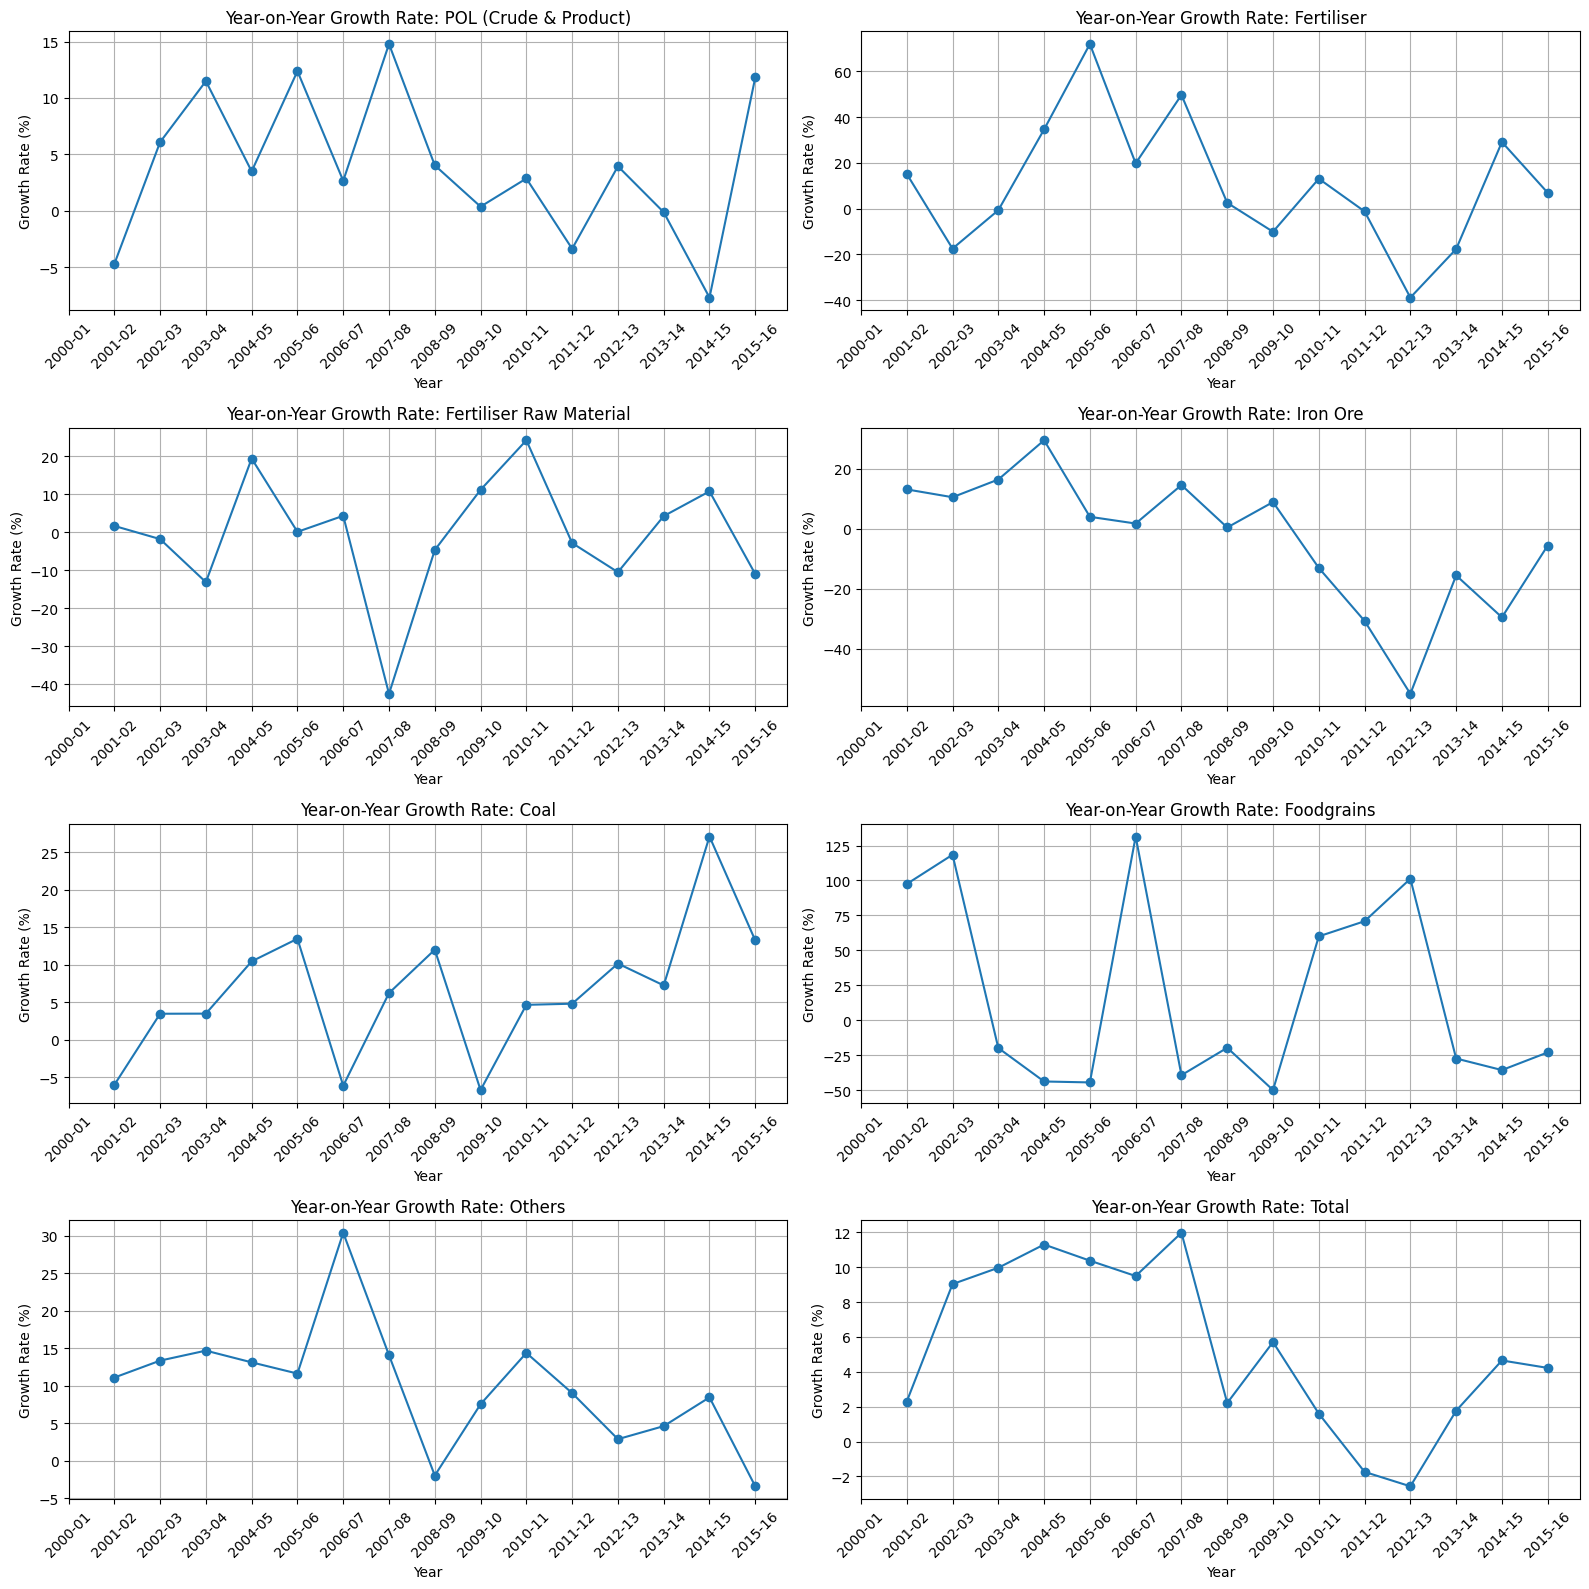

In [21]:
# Plot year-on-year growth rate for each commodity (excluding 'Total' and 'Year') with x-axis markers on all graphs

commodities = [col for col in df.columns[1:]]
years = df[year_col]

growth_rates = df[commodities].pct_change() * 100

fig, axes = plt.subplots(4, 2, figsize=(16, 16))  # Removed sharex=True
axes = axes.flatten()

for i, col in enumerate(commodities):
    axes[i].plot(years, growth_rates[col], marker='o')
    axes[i].set_title(f'Year-on-Year Growth Rate: {col}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Growth Rate (%)')
    axes[i].grid(True)
    axes[i].set_xticks(years)
    axes[i].set_xticklabels(years, rotation=45)

plt.tight_layout()
plt.show()


Forecast for year 2016:
POL (Crude & Product): 188.0389440479723
Fertiliser: 8.630816251026678
Fertiliser Raw Material: 7.608204921177458
Iron Ore: 14.806786078780972
Coal: 143.08090991189442
Foodgrains: 2.313890184568734
Others: 246.4107217660829


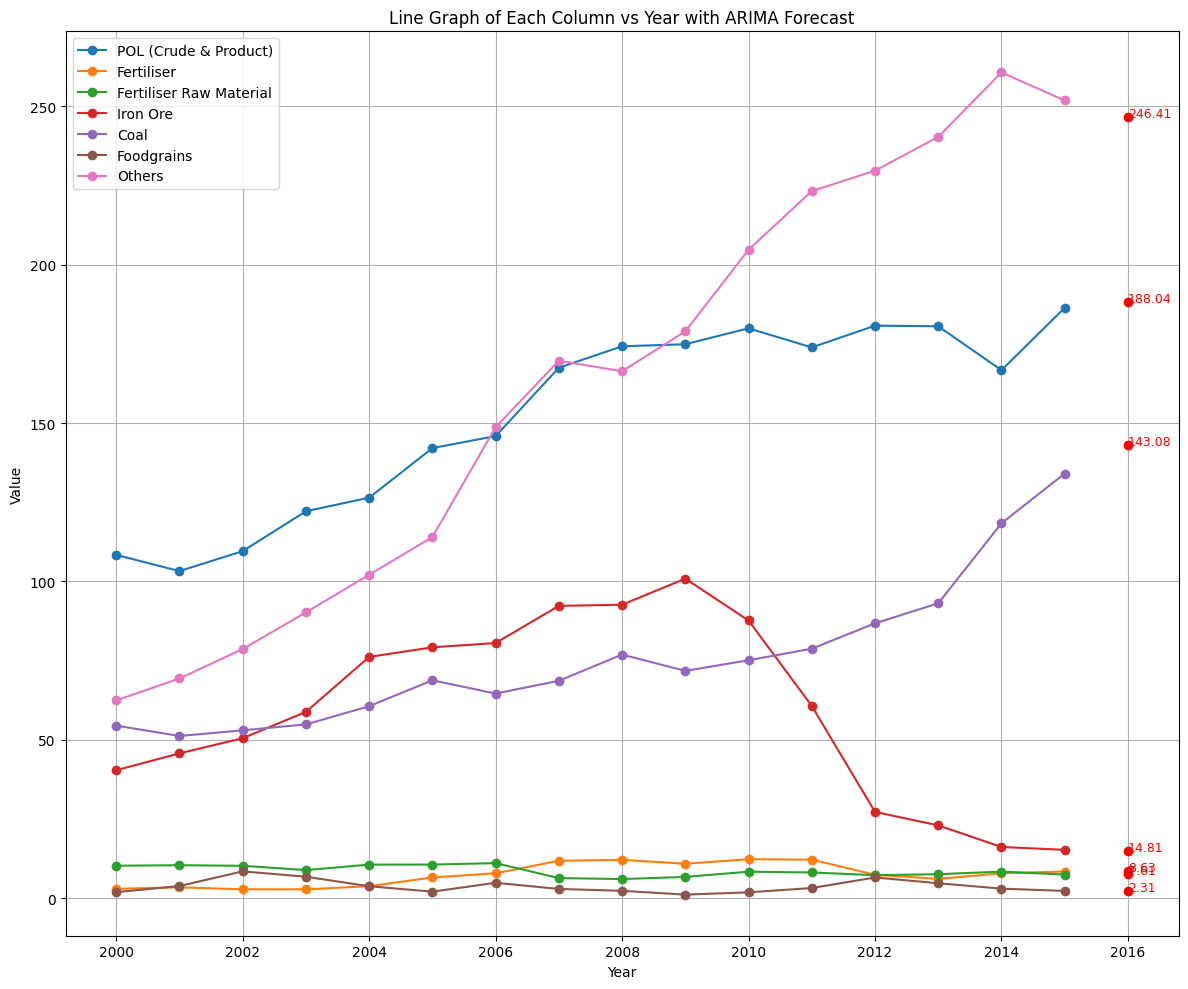

In [30]:
# Forecast next year's value for each commodity using ARIMA and plot the predictions
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

forecast_results = {}
next_year = df[year_col].str.extract(r'(\d{4})')[0].astype(int).max() + 1

for col in [c for c in df.columns[1:] if 'total' not in c.lower()]:
    series = df[col].dropna()
    try:
        model = ARIMA(series, order=(1,1,0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1).iloc[0]
        forecast_results[col] = forecast
    except Exception as e:
        forecast_results[col] = f'Error: {e}'

print(f"\nForecast for year {next_year}:")
for col, value in forecast_results.items():
    print(f"{col}: {value}")

# Plot actual and predicted values for each commodity
years = df[year_col].str.extract(r'(\d{4})')[0].astype(int)
plt.figure(figsize=(12, 10))
for col in [c for c in df.columns[1:] if 'total' not in c.lower()]:
    plt.plot(years, df[col], marker='o', label=col)
    # Plot the prediction as a red dot
    if not isinstance(forecast_results[col], str):
        plt.plot(next_year, forecast_results[col], marker='o', color='red')
        plt.text(next_year, forecast_results[col], f'{forecast_results[col]:.2f}', color='red', fontsize=9)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Line Graph of Each Column vs Year with ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

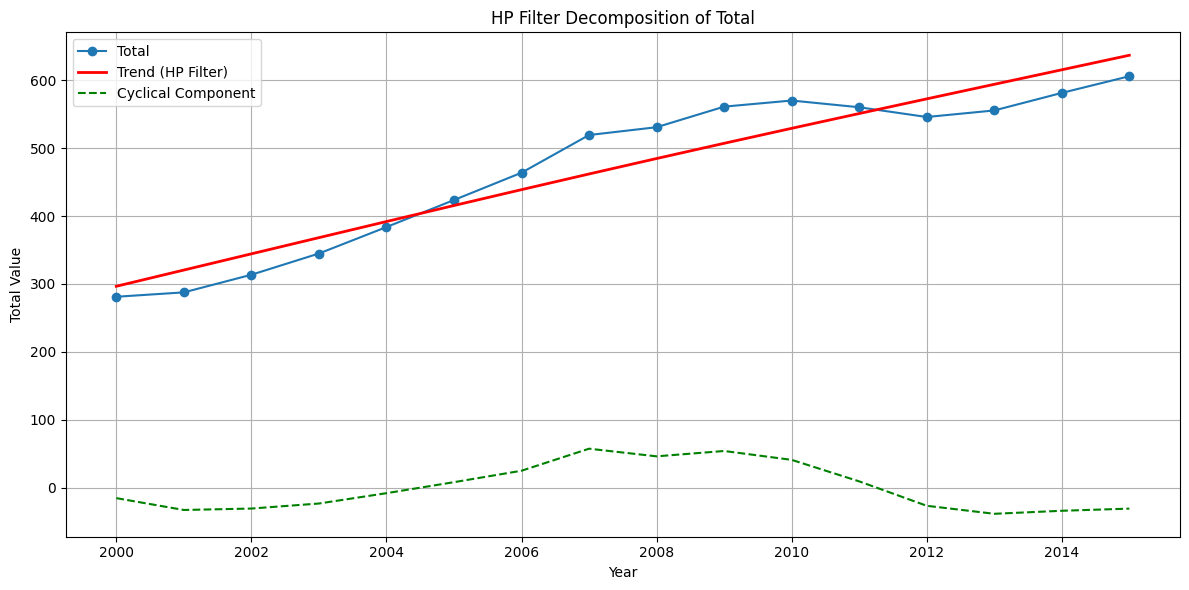

In [31]:
# Hodrick-Prescott (HP) filter on the Total column and plot the result
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt

# Extract the year as integer
years = df[year_col].str.extract(r'(\d{4})')[0].astype(int)
# Find the total column (case-insensitive)
total_col = [col for col in df.columns if 'total' in col.lower()]
if total_col:
    total_series = df[total_col[0]].dropna()
    cycle, trend = hpfilter(total_series, lamb=1600)
    plt.figure(figsize=(12, 6))
    plt.plot(years, total_series, label='Total', marker='o')
    plt.plot(years, trend, label='Trend (HP Filter)', color='red', linewidth=2)
    plt.plot(years, cycle, label='Cyclical Component', color='green', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel('Total Value')
    plt.title('HP Filter Decomposition of Total')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print('No Total column found in the data.')